In [1]:
from spacepy import pycdf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
from mpl_toolkits.mplot3d import axes3d
import matplotlib
import matplotlib.colors as colors
from collections import Counter
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import math
from lmfit.models import GaussianModel
from sklearn import mixture
from matplotlib.colors import LogNorm
from sklearn import cluster
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import pandas

# Machine Learning

In [2]:
npzfile = np.load('2003.npz')

start_dc = npzfile['arr_0']
end_dc = npzfile['arr_1']
start_c = npzfile['arr_2']
end_c = npzfile['arr_3']

date2 = pandas.Timestamp.date(start_dc[len(start_dc)-1])
#FGMfile = np.load(str(date2.year)+'_FGM.npz')
strahl_file = np.load(str(date2.year)+'_strahl.npz')

#B_dir = FGMfile['arr_0']
#print(np.shape(B_dir))

all_strahl_width_0 = strahl_file['arr_0']
all_strahl_width_180 = strahl_file['arr_1']

all_bp = []

for y in range(0,len(start_dc)):

    event = y
    #print(event)

    time = pandas.Timestamp.time(start_dc[event])
    date = pandas.Timestamp.date(start_dc[event])
    time1 = pandas.Timestamp.time(end_dc[event])
    date1 = pandas.Timestamp.date(end_dc[event])

    array = (date.year,date.month,date.day,time.hour,time.minute,time.second)
    array1 = (date1.year,date1.month,date1.day,time1.hour,time1.minute,time1.second)

    strs = ["" for x in range(6)]
    strs1 = ["" for x in range(6)]

    for i in range(len(array)):
        if array[i]<10:
            strs[i]='0'+str(array[i])
        else:
            strs[i]=str(array[i])
        if array1[i]<10:
            strs1[i]='0'+str(array1[i])
        else:
            strs1[i]=str(array1[i])

    stamp = strs[0]+strs[1]+strs[2]+'_'+strs[3]+strs[4]+strs[5]+'_'+strs1[0]+strs1[1]+strs1[2]+'_'+strs1[3]+strs1[4]+strs1[5]

    choose_file = '/Users/mayur/PhD/Cluster_data/Statistical_Study/PSD/PSD_DC/C2_CP_PEA_PITCH_SPIN_PSD__'+stamp+'_V170624.cdf'

    #print(choose_file)

    cdf = pycdf.CDF(choose_file)
    #for (i, item) in enumerate(cdf, start=0):
    #    print(i, item, cdf[i])
    
    epoch = cdf[0][...]

    #data_raw = cdf[26][...] #DEFlux
    data = cdf[26][...] #PSD
    
    energy = cdf[20][...]
    
    if len(energy) < 45:
        print(' ')
        continue
    
    if energy[0,0] < 0:
        print(' ')
        continue
    
    ### Only reshape data for DEFlux, not PSD 
    #data = []
        
    #for f in range(len(epoch)):
    #    a = data_raw[f].flatten()
    #    b = a.reshape(44,12,order='F')
    #    c = b.flatten()
    #    d = c.reshape(12,44)
    #    data.append(d)
    
    #data = np.array(data)
    
    pa = cdf[23][...]

    #print(energy[0,0:30])

    #ba = np.asscalar(np.where(energy[0]==173.09)[0]) #start of energy range bp analysis
    ba = np.asscalar(np.where(energy[0]==273.)[0]) #start of energy range bp analysis
    bb = np.asscalar(np.where(energy[0]==15.779)[0]) #end of energy range bp analysis
    sh = np.asscalar(np.where(energy[0]==534.17)[0]) #start of energy range suprathermal
    cs = np.asscalar(np.where(energy[0]==24.348)[0]) #end of energy range suprathermal
    
    
    bp_fluxes = []
    all_energies = []

        
    if all_strahl_width_0[event] < 7.5: #### if strahl width at the parallel pa we're looking at < 7.5 then halo
        print(' ')
        continue

    for i in range(0,len(epoch)):
        for j in range(ba,bb):
            flux = data[i,0:4,j]
        
            e = energy[0,j]
            all_energies.append(e)
        
            flux[flux == -1.] = 0.
       
            bp_fluxes.append(flux)

    #bp_fluxes = StandardScaler().fit_transform(bp_fluxes)
    #print(np.shape(bp_fluxes))
    
    n_clusters = 2
    
    bp = []
    k_means = cluster.KMeans(n_clusters)
    all_cluster_s = k_means.fit(bp_fluxes)
    
    all_cluster_s.labels_[all_cluster_s.labels_ == 2] = 1
    all_cluster_s.labels_[all_cluster_s.labels_ == 3] = 1
    all_cluster_s.labels_[all_cluster_s.labels_ == 4] = 1
    all_cluster_s.labels_[all_cluster_s.labels_ == 5] = 1

    for (i, item) in enumerate(all_cluster_s.labels_, start=0):
        if all_cluster_s.labels_[i]>all_cluster_s.labels_[i-1]:
            bp.append(all_energies[i-1])

    bp = np.array(bp)

                
    while np.mean(bp) < 22:
        bp = []
        k_means = cluster.KMeans(n_clusters)
        all_cluster_s = k_means.fit(bp_fluxes)
    
        all_cluster_s.labels_[all_cluster_s.labels_ == 2] = 1
        all_cluster_s.labels_[all_cluster_s.labels_ == 3] = 1
        all_cluster_s.labels_[all_cluster_s.labels_ == 4] = 1

        for (i, item) in enumerate(all_cluster_s.labels_, start=0):
            if all_cluster_s.labels_[i]>all_cluster_s.labels_[i-1]:
                bp.append(all_energies[i-1])
                
    while np.mean(bp) > 220:
        bp = []
        k_means = cluster.KMeans(n_clusters)
        all_cluster_s = k_means.fit(bp_fluxes)
    
        all_cluster_s.labels_[all_cluster_s.labels_ == 2] = 1
        all_cluster_s.labels_[all_cluster_s.labels_ == 3] = 1
        all_cluster_s.labels_[all_cluster_s.labels_ == 4] = 1

        for (i, item) in enumerate(all_cluster_s.labels_, start=0):
            if all_cluster_s.labels_[i]>all_cluster_s.labels_[i-1]:
                bp.append(all_energies[i-1])
    
    print(np.mean(bp))

 
30.12451
36.90065
 
31.920305
28.359001
37.50553
35.471153
73.81653
75.39047
49.890476
69.64014
82.66924
39.478127
 
61.806602
126.885345
29.71193
 
 
 
 
 
 
 
 
 
31.63133
31.2972
 
37.690388
38.13872
38.120136
37.713093
 
38.535744
37.66
 
37.68929
37.566555
 
36.422054
37.344624
37.680763
36.88352
37.423233
37.873146
37.042377
37.61879
37.1606
36.340637
37.071987
37.438316
 
37.53489
 
37.354183
37.428364
37.612392
 
37.42864
37.43406
36.832867
36.419407
37.32855
37.4406
35.837944
30.27743
30.326305
31.700754
31.969263
32.131683
33.58438
32.125267
35.484116
34.79125
40.95923
38.398335
39.060688
39.243126
44.730064
47.280853
47.133545
48.926197
52.605694
51.26151
42.625633
72.96172
23.049417
39.02418
22.773447
41.173504
43.92551
46.928703
47.9296
40.31663
43.61085
31.22712
30.49586
31.753735
29.84635
29.94439
30.68976
29.700937
30.458715
30.814901
29.60687
31.990831
30.373955
29.970154
30.344015
30.154652
30.225212
30.95574
28.781591
28.773758
30.13804
30.25983
30.135984
30.443047

# Tests

In [37]:
#breakpoint at 90 degrees

ymean_90 = []
yt_90 = []

    
for n in range(ba,bb):
    for t in range(0,len(epoch)):
        y_90 = data[10,5:7,n]
        ymean_90.append(y_90)
        
        ym_90 = np.mean(ymean_90)
    yt_90.append(ym_90)

14 27


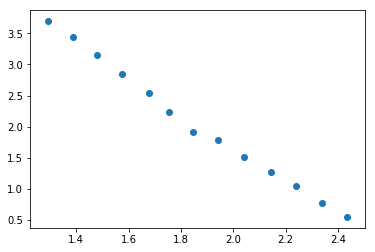

In [38]:
plt.scatter(np.log10(energy[0,ba:bb]),np.log10(yt_90),label='averaged data')
print(ba,bb)

[6120.9   4911.    3952.    3156.1   2531.    2030.1   1621.7   1296.2
 1039.9    832.28   669.21   534.17   428.84   342.73   273.     217.89
  173.09   139.08   110.09    87.464   70.462   56.717   47.865   37.66
   30.091   24.348   19.568   15.779   12.543   10.073]


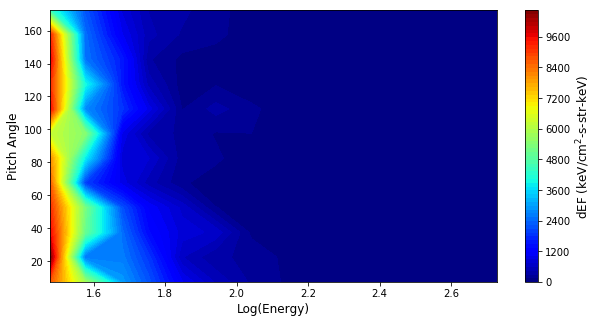

In [39]:
time = 50
    
#PITCH_SPIN 2D plotting:
X, Y = np.meshgrid(energy[time,sh:cs],pa)
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
D = data[time,0:len(pa),sh:cs]
surf = ax.contourf(np.log10(X), Y, D, 100, cmap=cm.jet)
cbar = fig.colorbar(surf)
cbar.set_label('dEF (keV/cm$^{2}$-s-str-keV)',fontsize=12)
ax.set_ylabel('Pitch Angle',fontsize=12)
ax.set_xlabel('Log(Energy)',fontsize=12)
#ax.set_xlim(0,5)

print(energy[time,0:30])


### 0 and 180 degrees BP

In [10]:
#breakpoint at 0 degrees

ymean_0 = []
yt_0 = []

    
for n in range(14,36):
    for t in range(0,len(epoch)):
        y_0 = data[t,0,n]
        ymean_0.append(y_0)
        
        ym_0 = np.mean(ymean_0)
    yt_0.append(ym_0)

In [138]:
#breakpoint at 180 degrees

ymean_180 = []
yt_180 = []

    
for n in range(12,30):
    for t in range(0,len(epoch)):
        y_180 = data[t,11,n]
        ymean_180.append(y_180)
        
        ym_180 = np.mean(ymean_180)
    yt_180.append(ym_180)